In [21]:
import xarray as xr
import numpy as np
import regionmask
import geopandas as gpd
import matplotlib.pyplot as plt
from pandas import date_range
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Load data

In [3]:
## Loading dataset and cropping only the Indian region

ds_tmax_2023 = xr.open_dataset('tmax.2023.nc').sel(lat=slice(40,5),lon=slice(65,100))
ds_tmax_2024 = xr.open_dataset('tmax.2024.nc').sel(lat=slice(40,5),lon=slice(65,100))
ds_tmin_2023 = xr.open_dataset('tmin.2023.nc').sel(lat=slice(40,5),lon=slice(65,100))
ds_tmin_2024 = xr.open_dataset('tmin.2024.nc').sel(lat=slice(40,5),lon=slice(65,100))
ds_tmin_clim = xr.open_dataset('tmin.day.ltm.1991-2020.nc').sel(lat=slice(40,5),lon=slice(65,100))
ds_tmax_clim = xr.open_dataset('tmax.day.ltm.1991-2020.nc').sel(lat=slice(40,5),lon=slice(65,100))

ds_precip_2023 = xr.open_dataset('precip_2023.nc').sel(lat=slice(40,5),lon=slice(65,100))
ds_precip_2024 = xr.open_dataset('precip_2024.nc').sel(lat=slice(40,5),lon=slice(65,100))
ds_precip_clim = xr.open_dataset('precip_day_ltm_1991_2020.nc').sel(lat=slice(40,5),lon=slice(65,100))

C:\Users\li3n23\miniforge3\envs\Work\Lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'rasterio' loading failed:
module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
C:\Users\li3n23\miniforge3\envs\Work\Lib\site-packages\xarray\coding\times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cfti

## Merge 2023 and 2024 data


In [4]:
ds_tmax = xr.concat([ds_tmax_2023, ds_tmax_2024], dim='time') 
ds_tmin = xr.concat([ds_tmin_2023, ds_tmin_2024], dim='time')
ds_precip = xr.concat([ds_precip_2023, ds_precip_2024], dim='time')

## Load the shapefile of India and create mask

In [5]:
india_geojson = 'geoBoundaries-IND-ADM0_simplified.geojson'#
india_gdf = gpd.read_file(india_geojson)

In [6]:
mask = regionmask.mask_3D_geopandas(india_gdf, ds_tmax['lon'], ds_tmax['lat'])


In [7]:
masked_tmax = ds_tmax.where(mask)
masked_tmin = ds_tmin.where(mask)
masked_precip = ds_precip.where(mask)

masked_tmax_clim = ds_tmax_clim.where(mask)
masked_tmin_clim = ds_tmin_clim.where(mask)
masked_precip_clim = ds_precip_clim.where(mask)


## Compute mean temperature from max and min temperatures

In [8]:
tmean = (masked_tmax.tmax + masked_tmin.tmin) / 2
tmean =tmean.sel(time=slice('2023-05-01','2024-04-29'))

tmean_clim = (masked_tmax_clim.tmax + masked_tmin_clim.tmin) / 2


In [9]:
precip =masked_precip.precip.sel(time=slice('2023-05-01','2024-04-29'))

precip_clim = masked_precip_clim.precip


## Shifting the data such that it starts from May 1 and end at April 29

In [10]:
start_date = '2023-05-01'
start_date_dt = np.datetime64(start_date)
start_day_of_year = (start_date_dt - np.datetime64(f'{start_date[:4]}-01-01')).astype('timedelta64[D]').astype(int)


In [11]:
## Compute spatial mean

tmean_ind = tmean.mean(['lat','lon']).squeeze()
tmean_clim_ind = tmean_clim.mean(['lat','lon']).squeeze()

In [12]:
## Compute spatial mean

precip_ind = precip.mean(['lat','lon']).squeeze()
precip_clim_ind = precip_clim.mean(['lat','lon']).squeeze()

In [13]:
# Calculate the day of the year for May 1 to determine the shift amount
start_date = np.datetime64('2023-05-01')
day_of_year_start = (start_date - np.datetime64('2023-01-01')).astype('timedelta64[D]').astype(int)

# Cyclically shift the climatology data values using numpy roll
climatology_shifted_values = np.roll(tmean_clim_ind.values, -day_of_year_start)

# Determine the length of the climatology data
length_of_climatology = len(tmean_clim_ind.time)

# Create the desired time range from May 1 to April 30 of the following year
new_time_index = date_range(start='2023-05-01', periods=length_of_climatology)

# Create a new DataArray for shifted climatology with the new time coordinates
tmean_clim_ind_s = xr.DataArray(climatology_shifted_values, coords=[new_time_index], dims=['time'])


In [14]:
# Calculate the day of the year for May 1 to determine the shift amount
start_date = np.datetime64('2023-05-01')
day_of_year_start = (start_date - np.datetime64('2023-01-01')).astype('timedelta64[D]').astype(int)

# Cyclically shift the climatology data values using numpy roll
climatology_shifted_values = np.roll(precip_clim_ind.values, -day_of_year_start)

# Determine the length of the climatology data
length_of_climatology = len(precip_clim_ind.time)

# Create the desired time range from May 1 to April 30 of the following year
new_time_index = date_range(start='2023-05-01', periods=length_of_climatology)

# Create a new DataArray for shifted climatology with the new time coordinates
precip_clim_ind_s = xr.DataArray(climatology_shifted_values, coords=[new_time_index], dims=['time'])


## Compute monthly anomalies

In [16]:
tmean_clim_grouped = tmean_clim_ind_s.groupby('time.dayofyear')
tmean_anomaly = tmean_ind.groupby('time.dayofyear') - tmean_clim_grouped.mean('time')

In [17]:
precip_clim_grouped = precip_clim_ind_s.groupby('time.dayofyear')
precip_anomaly = precip_ind.groupby('time.dayofyear') - precip_clim_grouped.mean('time')

In [18]:
tmean_v = tmean.groupby('time.month').mean().squeeze()
tmean_v_clim = tmean_clim.groupby('time.month').mean().squeeze()
tmean_v_ano = tmean_v-tmean_v_clim

In [19]:
precip_v = precip.groupby('time.month').mean().squeeze()
precip_v_clim = precip_clim.groupby('time.month').mean().squeeze()
precip_v_ano = precip_v-precip_v_clim

## Plotting

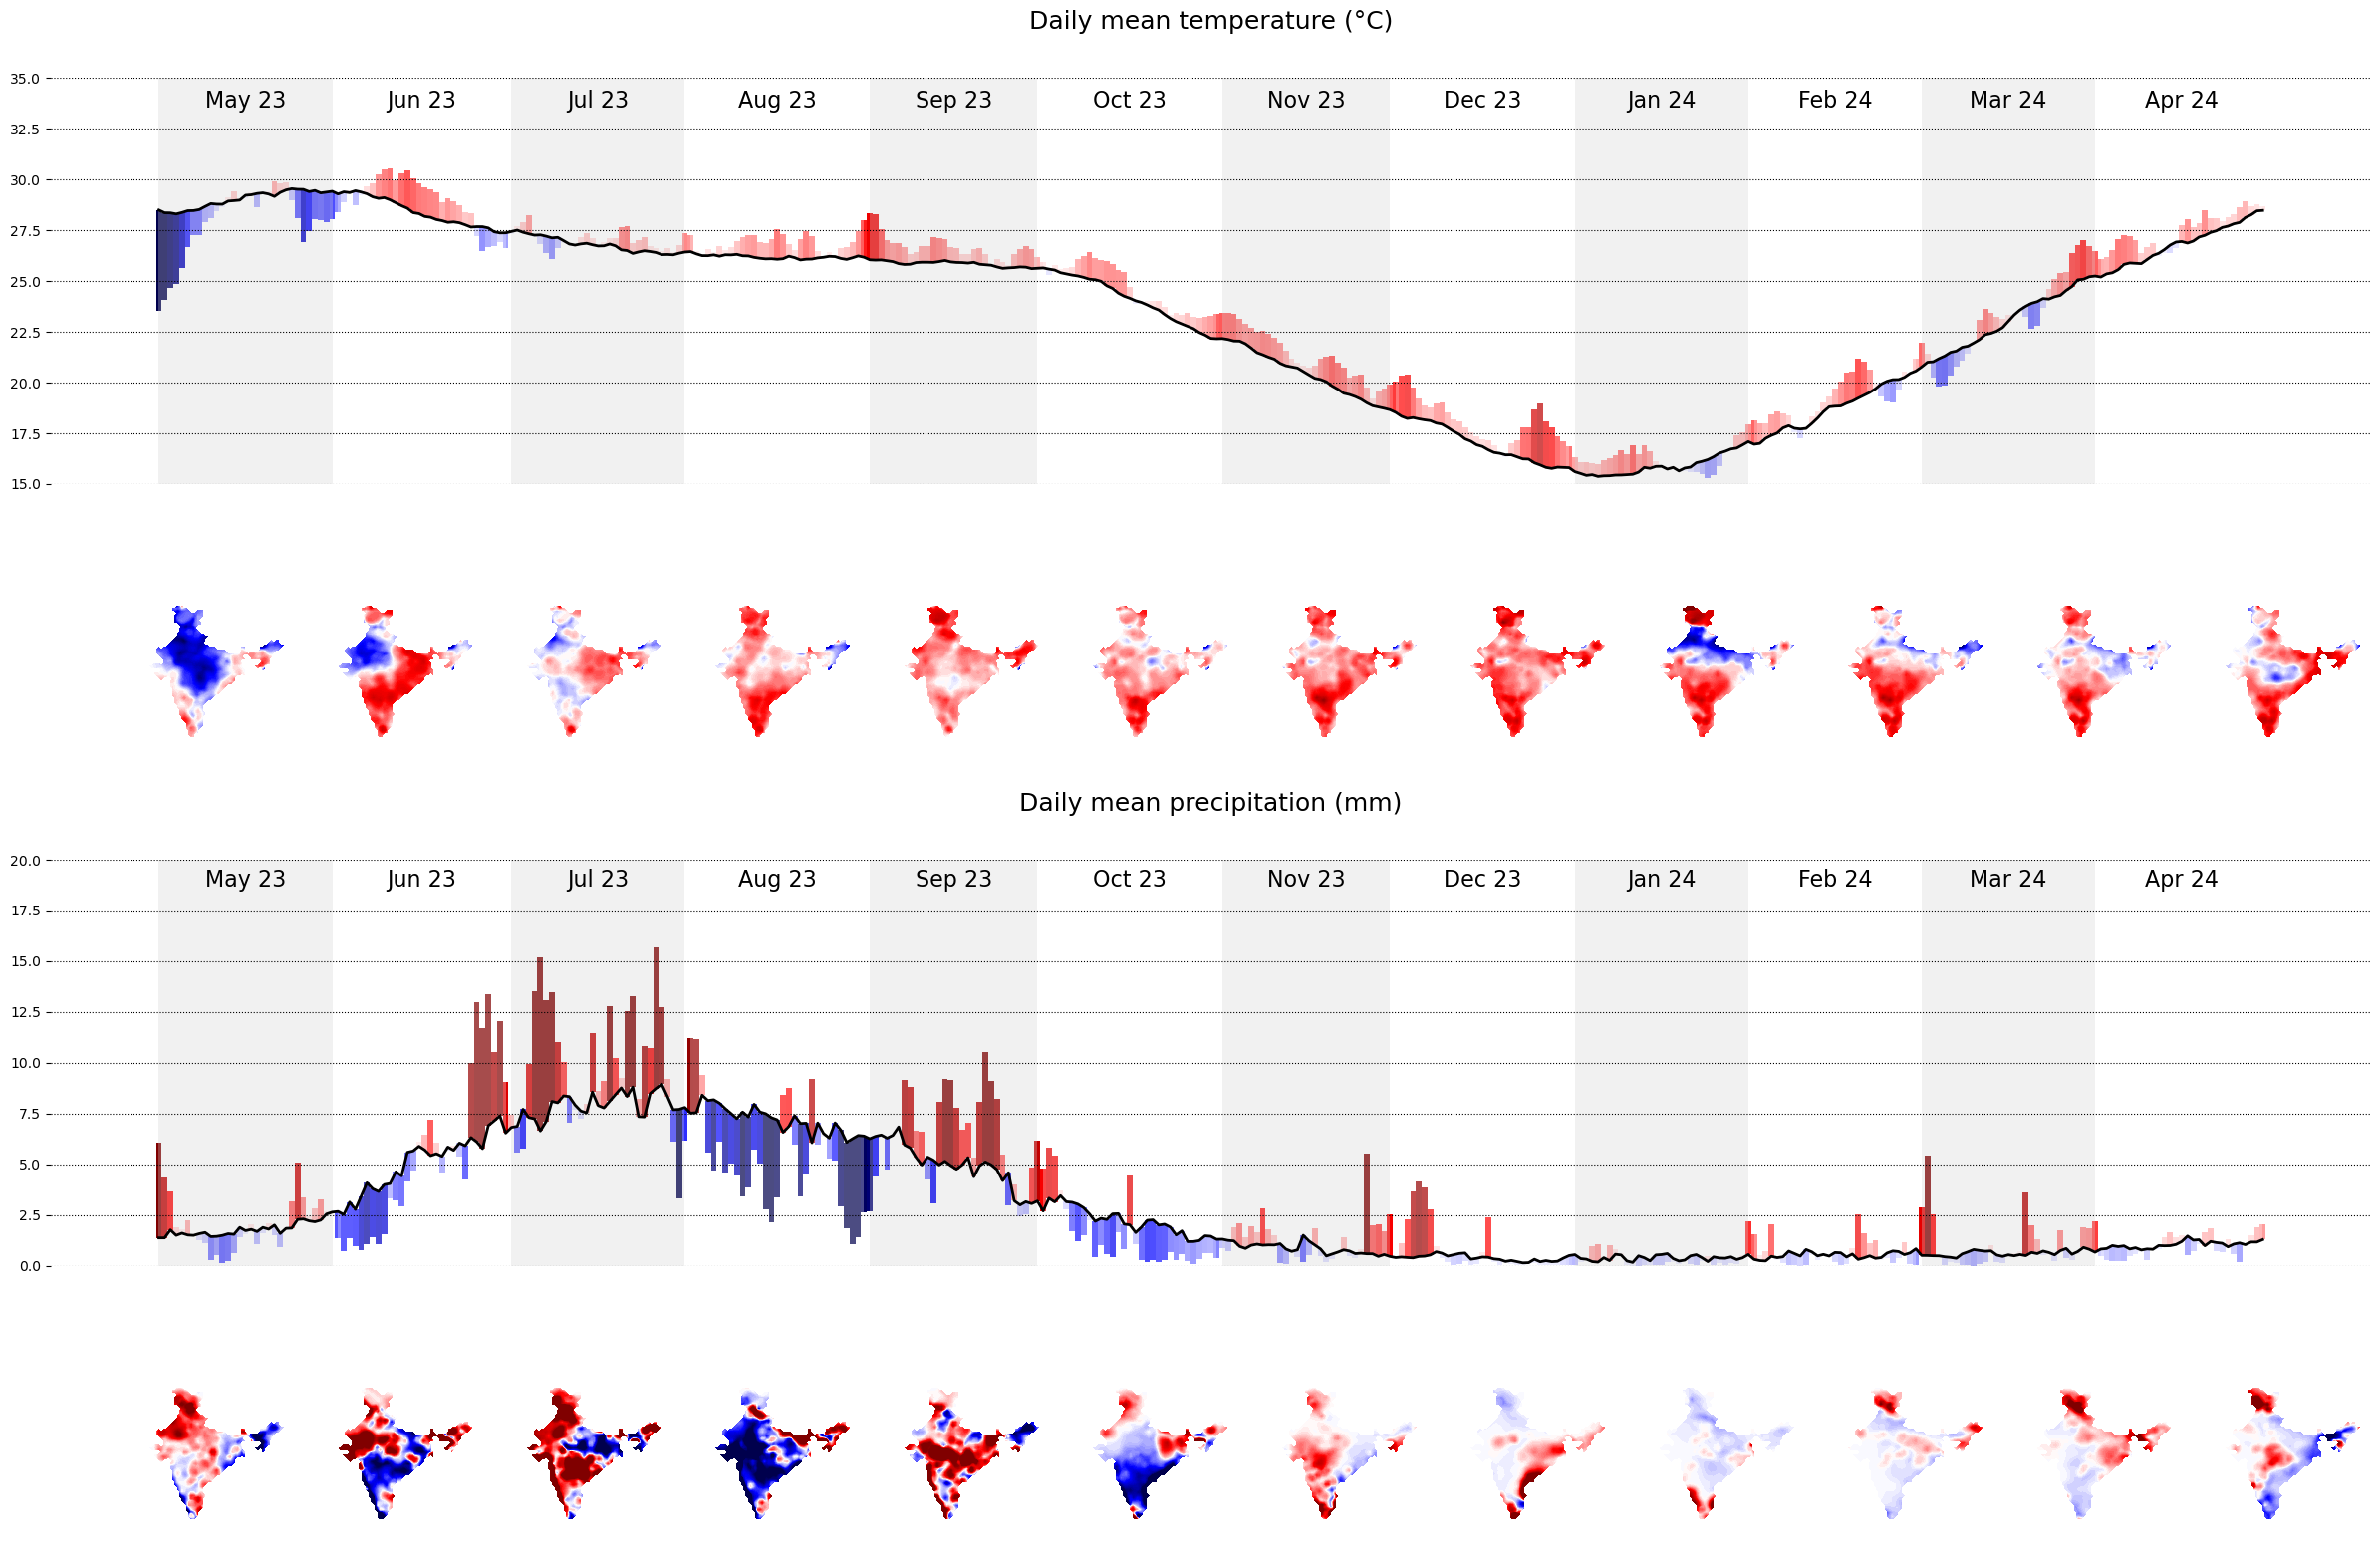

In [22]:
# Define the colormap
cmap = plt.get_cmap('seismic')

# Create a figure with 4 rows and 1 column (4x1 layout)
fig, (ax_temp_top, ax_temp_bottom, ax_precip_top, ax_precip_bottom) = plt.subplots(
    4, 1, figsize=(24, 16), sharex=True, gridspec_kw={'height_ratios': [1, 0.5, 1, 0.5]}
)

# Define custom levels for the colormap for both temperature and precipitation
levels = np.arange(-4, 4.1, 0.1)

# Plot the time series for temperature
tmean_clim_ind_s.plot(ax=ax_temp_top, color='black', label='Rolling Mean (30 days)', linewidth=2)
bar_colors_temp = cmap((tmean_anomaly.values - levels.min()) / (levels.max() - levels.min()))
ax_temp_top.bar(tmean_anomaly.time.values, tmean_anomaly.values, bottom=tmean_clim_ind_s.values, color=bar_colors_temp, label='Daily Values Anomalies', width=1.0)

# Iterate through each month to create alternating shaded regions in the temperature top panel
for i, (start_date, end_date) in enumerate(zip(tmean_anomaly.time.resample(time='M').first(), tmean_anomaly.time.resample(time='M').last())):
    # Convert DataArray values to scalar date-time objects
    start_date = pd.Timestamp(start_date.values)
    end_date = pd.Timestamp(end_date.values)

    # Alternate between light grey and white for shading
    color = 'lightgrey' if i % 2 == 0 else 'white'
    
    # Shade the month in the temperature top panel
    ax_temp_top.axvspan(start_date, end_date, facecolor=color, alpha=0.3)
    
    # Calculate the midpoint date of the month
    mid_date = start_date + (end_date - start_date) / 2
    
    # Format the month label with the last 2 digits of the year and the month name
    month_label = pd.Timestamp(mid_date).strftime('%b %y')
    
    # Add the formatted month name above the bar
    ax_temp_top.text(mid_date, ax_temp_top.get_ylim()[1] + 2, month_label, va='bottom', ha='center', fontsize=16)

# Customize the temperature top panel
ax_temp_top.set_title('Daily mean temperature (°C)', y=1.1, fontsize=18)
ax_temp_top.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax_temp_top.yaxis.grid(True, linestyle=':', color='black')
ax_temp_top.set_ylim(15, 35)
ax_temp_top.spines['top'].set_visible(False)
ax_temp_top.spines['right'].set_visible(False)
ax_temp_top.spines['bottom'].set_visible(False)
ax_temp_top.spines['left'].set_visible(False)
ax_temp_top.set_xlabel('')

# Plot spatial plots for temperature
grid_spec_temp = ax_temp_bottom.get_subplotspec().subgridspec(
    1, 13, width_ratios=[0.35] + [1] * 12
)

# Iterate through each month and plot spatial maps for temperature
for i, month in enumerate(list(range(5, 13)) + list(range(1, 5))):
    subplot_index = i + 1  # Shift indices after the first blank column

    ax_month_temp = fig.add_subplot(grid_spec_temp[subplot_index], projection=ccrs.PlateCarree())
    month_data_temp = tmean_v_ano.sel(month=month)
    ax_month_temp.contourf(month_data_temp.lon, month_data_temp.lat, month_data_temp.values, cmap=cmap, transform=ccrs.PlateCarree(), levels=levels, extend='both')
    #ax_month_temp.add_feature(cfeature.BORDERS, edgecolor='black')
    ax_month_temp.set_xticks([])
    ax_month_temp.set_yticks([])
    ax_month_temp.axis('off')

# Plot the time series for precipitation
precip_clim_ind_s.plot(ax=ax_precip_top, color='black', label='Rolling Mean (30 days)', linewidth=2)
bar_colors_precip = cmap((precip_anomaly.values - levels.min()) / (levels.max() - levels.min()))

ax_precip_top.bar(precip_anomaly.time.values, precip_anomaly.values, bottom=precip_clim_ind_s.values, color=bar_colors_precip, label='Daily Values Anomalies', width=1.0)

# Iterate through each month to create alternating shaded regions in the precipitation top panel
for i, (start_date, end_date) in enumerate(zip(tmean_anomaly.time.resample(time='M').first(), tmean_anomaly.time.resample(time='M').last())):
    # Convert DataArray values to scalar date-time objects
    start_date = pd.Timestamp(start_date.values)
    end_date = pd.Timestamp(end_date.values)

    # Alternate between light grey and white for shading
    color = 'lightgrey' if i % 2 == 0 else 'white'
    
    # Shade the month in the precipitation top panel
    ax_precip_top.axvspan(start_date, end_date, facecolor=color, alpha=0.3)
    
    # Calculate the midpoint date of the month
    mid_date = start_date + (end_date - start_date) / 2
    
    # Format the month label with the last 2 digits of the year and the month name
    month_label = pd.Timestamp(mid_date).strftime('%b %y')
    
    # Add the formatted month name above the bar
    ax_precip_top.text(mid_date, ax_precip_top.get_ylim()[1] + 2, month_label, va='bottom', ha='center', fontsize=16)

# Customize the precipitation top panel
ax_precip_top.set_title('Daily mean precipitation (mm)', y=1.1, fontsize=18)
ax_precip_top.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax_precip_top.yaxis.grid(True, linestyle=':', color='black')
ax_precip_top.set_ylim(0, 20)
ax_precip_top.spines['top'].set_visible(False)
ax_precip_top.spines['right'].set_visible(False)
ax_precip_top.spines['bottom'].set_visible(False)
ax_precip_top.spines['left'].set_visible(False)
ax_precip_top.set_xlabel('')

# Plot spatial plots for precipitation
grid_spec_precip = ax_precip_bottom.get_subplotspec().subgridspec(
    1, 13, width_ratios=[0.35] + [1] * 12
)

# Iterate through each month and plot spatial maps for precipitation
for i, month in enumerate(list(range(5, 13)) + list(range(1, 5))):
    subplot_index = i + 1  # Shift indices after the first blank column

    ax_month_precip = fig.add_subplot(grid_spec_precip[subplot_index], projection=ccrs.PlateCarree())
    month_data_precip = precip_v_ano.sel(month=month)
    ax_month_precip.contourf(month_data_precip.lon, month_data_precip.lat, month_data_precip.values, cmap=cmap, transform=ccrs.PlateCarree(), levels=levels, extend='both')
    #ax_month_precip.add_feature(cfeature.BORDERS, edgecolor='black')
    ax_month_precip.set_xticks([])
    ax_month_precip.set_yticks([])
    ax_month_precip.axis('off')
ax_precip_bottom.spines['top'].set_visible(False)
ax_precip_bottom.spines['right'].set_visible(False)
ax_precip_bottom.spines['bottom'].set_visible(False)
ax_precip_bottom.spines['left'].set_visible(False)
ax_precip_bottom.set_xlabel('')

ax_temp_bottom.spines['top'].set_visible(False)
ax_temp_bottom.spines['right'].set_visible(False)
ax_temp_bottom.spines['bottom'].set_visible(False)
ax_temp_bottom.spines['left'].set_visible(False)
ax_temp_bottom.set_xlabel('')
# Adjust the layout
fig.tight_layout()
ax_precip_bottom.set_xlabel('')
ax_temp_bottom.set_xticks([])
ax_precip_bottom.set_xticks([])
ax_temp_bottom.set_yticks([])
ax_precip_bottom.set_yticks([])

# Save the figure as a PDF file
fig.savefig('combined_figure.pdf', format='pdf')

# Show the plot
plt.show()
